# Lab | Making predictions with logistic regression

In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.

**Instructions**

* Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).
* Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.
* Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.
* Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.
* Create a logistic regression model to predict 'rented_in_may' from the cleaned data.
* Evaluate the results.


In [1]:
# libraries 

import pandas as pd
import numpy as np
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [3]:
# To get the password without showing the input

import getpass

In [4]:
# Getting the password
password = getpass.getpass()

········


In [5]:
# Creating the connection with mysql

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [6]:
# the sql query

query = '''
SELECT film.*, MAX(CASE WHEN rental.rental_date IS NOT NULL THEN 1 ELSE 0 END) AS rented_in_may
FROM film
LEFT JOIN inventory ON film.film_id = inventory.film_id
LEFT JOIN rental ON inventory.inventory_id = rental.inventory_id 
AND EXTRACT(MONTH FROM rental.rental_date) = 5 AND EXTRACT(YEAR FROM rental.rental_date) = 2005
GROUP BY film.film_id, film.rental_rate, film.length, film.rating'''


In [7]:
movies = pd.read_sql_query(query, engine)
movies

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,rented_in_may
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,1
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2006-02-15 05:03:42,0
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,None,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2006-02-15 05:03:42,1
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,None,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",2006-02-15 05:03:42,1
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,6,2.99,130,22.99,G,Deleted Scenes,2006-02-15 05:03:42,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,A Unbelieveable Yarn of a Boat And a Database ...,2006,1,None,6,0.99,183,9.99,G,"Trailers,Behind the Scenes",2006-02-15 05:03:42,0
996,997,YOUTH KICK,A Touching Drama of a Teacher And a Cat who mu...,2006,1,None,4,0.99,179,14.99,NC-17,"Trailers,Behind the Scenes",2006-02-15 05:03:42,0
997,998,ZHIVAGO CORE,A Fateful Yarn of a Composer And a Man who mus...,2006,1,None,6,0.99,105,10.99,NC-17,Deleted Scenes,2006-02-15 05:03:42,1
998,999,ZOOLANDER FICTION,A Fateful Reflection of a Waitress And a Boat ...,2006,1,None,5,2.99,101,28.99,R,"Trailers,Deleted Scenes",2006-02-15 05:03:42,1


In [8]:
# we first dropped "obvious" columns like film id, description and last update
# then we dropped language_id because there is only 1 id and original_language_id because it only has none values
# we drop release year because all the movies have been released on the same year
# initially dropping special features,is not clear that it will be usefull and will give a lot of work,
# but we can always readd it in th

In [9]:
print(list(movies.columns),sep=',')

['film_id', 'title', 'description', 'release_year', 'language_id', 'original_language_id', 'rental_duration', 'rental_rate', 'length', 'replacement_cost', 'rating', 'special_features', 'last_update', 'rented_in_may']


In [10]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   film_id               1000 non-null   int64         
 1   title                 1000 non-null   object        
 2   description           1000 non-null   object        
 3   release_year          1000 non-null   int64         
 4   language_id           1000 non-null   int64         
 5   original_language_id  0 non-null      object        
 6   rental_duration       1000 non-null   int64         
 7   rental_rate           1000 non-null   float64       
 8   length                1000 non-null   int64         
 9   replacement_cost      1000 non-null   float64       
 10  rating                1000 non-null   object        
 11  special_features      1000 non-null   object        
 12  last_update           1000 non-null   datetime64[ns]
 13  rented_in_may      

In [11]:
list(movies.columns)

['film_id',
 'title',
 'description',
 'release_year',
 'language_id',
 'original_language_id',
 'rental_duration',
 'rental_rate',
 'length',
 'replacement_cost',
 'rating',
 'special_features',
 'last_update',
 'rented_in_may']

In [12]:
# drop extra columns

drop_list = ['film_id','description','release_year','language_id','original_language_id','special_features','last_update']
movies.drop(columns=drop_list,inplace=True)
movies

,title,rental_duration,rental_rate,length,replacement_cost,rating,rented_in_may
0,ACADEMY DINOSAUR,6,0.99,86,20.99,PG,1
1,ACE GOLDFINGER,3,4.99,48,12.99,G,0
2,ADAPTATION HOLES,7,2.99,50,18.99,NC-17,1
3,AFFAIR PREJUDICE,5,2.99,117,26.99,G,1
4,AFRICAN EGG,6,2.99,130,22.99,G,1
...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,6,0.99,183,9.99,G,0
996,YOUTH KICK,4,0.99,179,14.99,NC-17,0
997,ZHIVAGO CORE,6,0.99,105,10.99,NC-17,1
998,ZOOLANDER FICTION,5,2.99,101,28.99,R,1


In [13]:
# checking for nan values

movies.isna().sum()   # no null values

title               0
rental_duration     0
rental_rate         0
length              0
replacement_cost    0
rating              0
rented_in_may       0
dtype: int64

C:\Users\roba\AppData\Local\Temp\ipykernel_12036\1640923458.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = movies.corr()


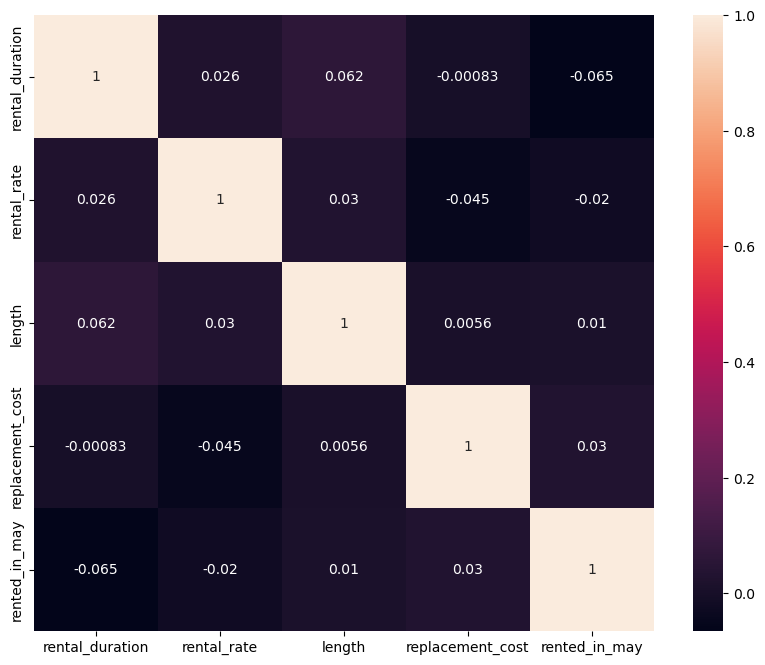

In [14]:
# checking for multicolinearity

corr_matrix = movies.corr()
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [15]:
# movies.info()

In [16]:
# removeing title from df because it will trigger too many columns when one hot encoding 

movies = movies.drop(columns=['title'])

# separate target from features

movies_y = movies['rented_in_may']
movies_X = movies.drop('rented_in_may', axis=1)

# separating numerical and categorical

movies_X_num = movies_X.select_dtypes(include = np.number)
movies_X_cat = movies_X.select_dtypes(include = object)

# training test split

X_train, X_test, y_train, y_test = train_test_split(movies_X, movies_y, test_size=0.2, random_state=1337)

In [19]:
X_train_num = X_train.select_dtypes(include = np.number)

# Scaling the data

transformer = MinMaxScaler().fit(X_train_num)
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns=movies_X_num.columns)

In [20]:
X_train_norm

,rental_duration,rental_rate,length,replacement_cost
0,0.50,1.0,0.769784,0.70
1,0.75,0.0,0.151079,0.65
2,0.00,0.5,0.258993,1.00
3,0.50,1.0,0.223022,0.70
4,0.25,0.0,0.733813,0.65
...,...,...,...,...
795,0.50,0.0,0.151079,0.70
796,0.00,0.0,0.683453,0.40
797,0.00,1.0,0.467626,0.15
798,0.50,1.0,0.906475,0.70


In [21]:
X_train_cat = X_train.select_dtypes(include = object)
X_test_cat  = X_test.select_dtypes(include = object)

In [22]:
# encode categoricals

encoder = OneHotEncoder(drop='first').fit(X_train_cat)
encoded_cat = encoder.transform(X_train_cat).toarray()
cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)

In [23]:
# we will reuse encoder and cols when encoding the X_test_cat

X_train_cat = pd.DataFrame(encoded_cat, columns=cols)
X_train_cat

,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
795,0.0,0.0,0.0,1.0
796,0.0,1.0,0.0,0.0
797,0.0,0.0,0.0,1.0
798,1.0,0.0,0.0,0.0


In [24]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)
X_train_transformed

array([[0.5       , 1.        , 0.76978417, ..., 0.        , 0.        ,
        0.        ],
       [0.75      , 0.        , 0.15107914, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.5       , 0.25899281, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 1.        , 0.4676259 , ..., 0.        , 0.        ,
        1.        ],
       [0.5       , 1.        , 0.90647482, ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.5       , 0.31654676, ..., 0.        , 1.        ,
        0.        ]])

In [25]:
# now we are transforming our TEST data

X_test_num = X_test.select_dtypes(include = np.number)   # for numericals

In [26]:
# Scaling data

X_test_normalized = transformer.transform(X_test_num)   # we use the transformer that was trained on the training data
X_test_norm = pd.DataFrame(X_test_normalized,columns = X_test_num.columns)
X_test_norm.head()

,rental_duration,rental_rate,length,replacement_cost
0,0.00,0.0,0.374101,0.15
1,0.75,0.5,0.964029,0.70
2,0.25,0.5,0.316547,0.45
3,1.00,0.5,0.618705,0.30
4,0.25,0.0,0.453237,0.35


In [27]:
# onehot encoding reusing the transformer for the test data

encoded_cat = encoder.transform(X_test_cat).toarray()
cols = encoder.get_feature_names_out(input_features=X_test_cat.columns)
X_test_cat = pd.DataFrame(encoded_cat, columns=cols)
X_test_cat

,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
195,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,1.0
197,1.0,0.0,0.0,0.0
198,1.0,0.0,0.0,0.0


In [28]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)
X_test_transformed

array([[0.        , 0.        , 0.37410072, ..., 0.        , 0.        ,
        1.        ],
       [0.75      , 0.5       , 0.96402878, ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 0.5       , 0.31654676, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [1.        , 0.5       , 0.27338129, ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 0.        , 0.29496403, ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 1.        , 0.4028777 , ..., 0.        , 0.        ,
        1.        ]])

In [29]:
# Building the logistic regression model

classification = LogisticRegression(random_state=0,
                                    solver='saga',
                                    multi_class='multinomial').fit(X_train_transformed, y_train)

In [30]:
# Predictions 

predictions = classification.predict(X_test_transformed)
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

In [31]:
classification.score(X_test_transformed, y_test)

0.69

In [32]:
# imbalance in the data 

print(y_test.value_counts())

1    138
0     62
Name: rented_in_may, dtype: int64


In [33]:
confusion_matrix(y_test, predictions)

array([[  0,  62],
       [  0, 138]], dtype=int64)

In [34]:
pd.Series(predictions).value_counts()

1    200
dtype: int64